In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from Bio.Seq import Seq
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
# multi dimensional scaling
from sklearn.manifold import MDS
# HDBSCAN
import umap

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embedding_path = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025_esmc_embeddings_results.pkl"
with open(embedding_path, "rb") as f:
    embeddings = pickle.load(f)
    

In [3]:
annot_path = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025.tsv"
df_annot = pd.read_csv(annot_path, sep="\t")

In [4]:
id_length_dict = df_annot.set_index("locus_tag")["length_bp"].to_dict()

In [5]:
selected_col = "mean_middle_layer"
df_mean = pd.DataFrame(embeddings).T[selected_col]

In [6]:
df_mean = pd.DataFrame(df_mean.explode(), columns = [selected_col]).reset_index().rename(columns={"index":"id"})

In [7]:
df_mean["Index"] = df_mean.groupby("id").cumcount()
df_pivot = df_mean.pivot(index="id", columns="Index", values=selected_col)
df_pivot.columns = [f"mean_{i}" for i in df_pivot.columns]
df_pivot = df_pivot.reset_index()

In [8]:
# pairwise cosine similarity between embeddings
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_pivot.iloc[:,1:])
cosine_sim = pd.DataFrame(cosine_sim, index=df_pivot["id"], columns=df_pivot["id"])


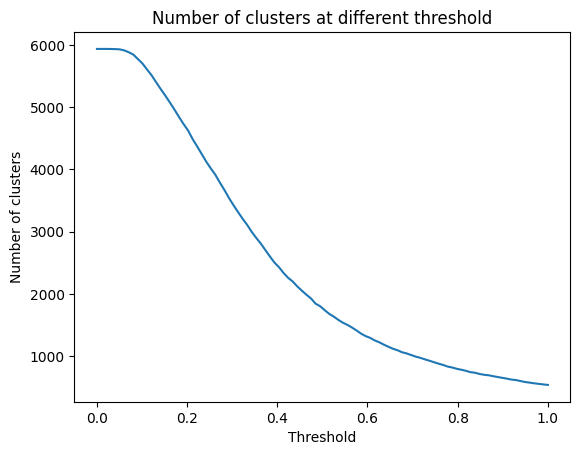

In [9]:
# perform hierarchical clustering on the cosine similarity matrix
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(cosine_sim, 'ward')
# obtain cluster 
from scipy.cluster.hierarchy import fcluster
# get number of clusters at different threshold
n_cluster = []
thresholds = np.linspace(0, 1, 100)
for t in thresholds:
    n_cluster.append(len(np.unique(fcluster(Z, t, criterion='distance'))))
plt.plot(thresholds, n_cluster)
plt.xlabel("Threshold")
plt.ylabel("Number of clusters")
plt.title("Number of clusters at different threshold")
plt.show()



0.0 5936
0.01001001001001001 5936
0.02002002002002002 5936
0.03003003003003003 5935
0.04004004004004004 5934
0.050050050050050046 5929
0.06006006006006006 5912
0.07007007007007007 5885
0.08008008008008008 5844
0.09009009009009009 5777
0.10010010010010009 5710
0.11011011011011011 5615
0.12012012012012012 5525
0.13013013013013014 5412
0.14014014014014015 5309
0.15015015015015015 5207
0.16016016016016016 5093
0.17017017017017017 4986
0.18018018018018017 4856
0.19019019019019018 4739
0.20020020020020018 4642
0.21021021021021022 4516
0.22022022022022023 4385
0.23023023023023023 4274
0.24024024024024024 4153
0.2502502502502503 4037
0.2602602602602603 3941
0.2702702702702703 3817
0.2802802802802803 3699
0.2902902902902903 3577
0.3003003003003003 3452
0.3103103103103103 3343
0.3203203203203203 3236
0.3303303303303303 3132
0.34034034034034033 3026
0.35035035035035034 2920
0.36036036036036034 2834
0.37037037037037035 2733
0.38038038038038036 2635
0.39039039039039036 2537
0.40040040040040037 2447

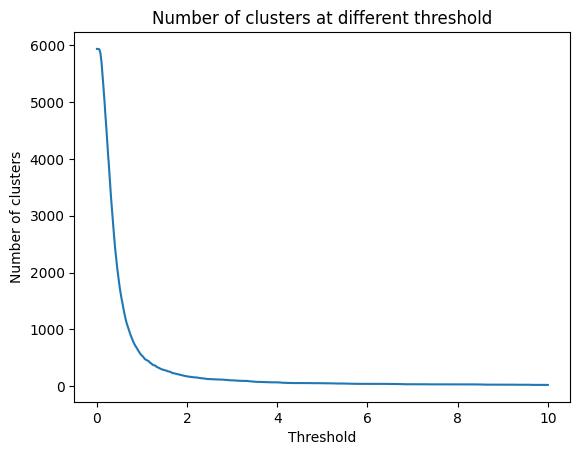

In [10]:
n_cluster = []
thresholds = np.linspace(0, 10, 1000)
for t in thresholds:
    n = len(np.unique(fcluster(Z, t, criterion='distance')))
    print(t, n)
    n_cluster.append(n)
plt.plot(thresholds, n_cluster)
plt.xlabel("Threshold")
plt.ylabel("Number of clusters")
plt.title("Number of clusters at different threshold")
plt.show()


In [15]:
from collections import Counter
count = Counter(n_cluster)
# sorted(count.items(), key=lambda x: x[0], reverse=False)[:100]

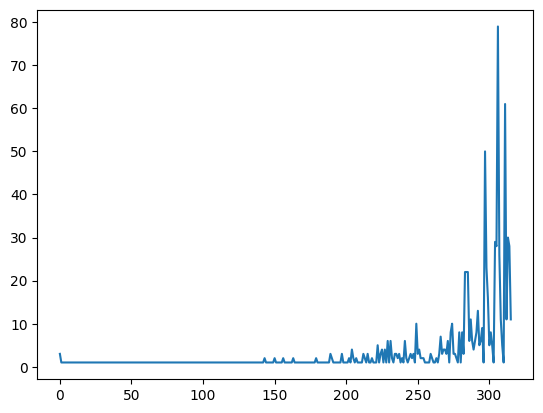

In [16]:
plt.Figure(figsize=(10, 10))
plt.plot(count.values())


In [107]:
# obtain 32 cluster from the dendrogram
cluster = fcluster(Z, 64, criterion='maxclust')


In [108]:
def cal_entropy(cluster):
    count = Counter(cluster)
    total = len(cluster)
    entropy = 0
    for c in count.values():
        entropy += c/total*np.log2(c/total)
    return -entropy

In [109]:
id_cluster_dict = dict(zip(df_pivot["id"], cluster))

In [110]:
df_annot["cluster"] = df_annot["locus_tag"].map(id_cluster_dict)

In [111]:
# fill cluster column na based on type column
# import label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_annot["ftype_label"] = le.fit_transform(df_annot["ftype"]) * -1
df_annot["cluster"] = df_annot["cluster"].fillna(df_annot["ftype_label"])


In [112]:
cal_entropy(df_annot["cluster"].iloc[4763:4763+50])

4.5683674395583775

In [63]:
import numpy as np

def compute_label_divergence(labels1, labels2, metric='js', smoothing=1e-10):
    """
    Compute divergence between two sequences of labels by comparing their probability distributions.
    
    Parameters:
        labels1, labels2 (list or tuple): Two sequences of labels.
        metric (str): Which divergence metric to use.
                      Options:
                        'kl' : symmetric KL divergence, computed as (KL(P||Q)+KL(Q||P))/2.
                        'js' : Jensen-Shannon divergence.
        smoothing (float): A small constant added to counts for numerical stability.
        
    Returns:
        divergence (float): The divergence value between the two distributions.
                            Lower values indicate greater similarity.
    """
    # Determine the complete set of unique labels in both sequences
    categories = sorted(set(labels1) | set(labels2))
    
    # Helper: compute the probability distribution for a list of labels
    def get_distribution(labels, categories):
        counts = np.array([labels.count(cat) for cat in categories], dtype=np.float64)
        counts += smoothing  # smoothing to avoid zeros
        distribution = counts / counts.sum()
        return distribution
    
    # Get probability distributions for both label sets
    p = get_distribution(labels1, categories)
    q = get_distribution(labels2, categories)
    
    # Define function to compute KL divergence
    def kl_divergence(p, q):
        return np.sum(p * np.log(p / q))
    
    if metric == 'kl':
        # Compute symmetric KL divergence: average of KL(P||Q) and KL(Q||P)
        divergence = 0.5 * (kl_divergence(p, q) + kl_divergence(q, p))
    elif metric == 'js':
        # Compute Jensen-Shannon divergence, which is symmetric and always finite
        m = 0.5 * (p + q)
        divergence = 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))
    else:
        raise ValueError("Unsupported metric. Choose 'kl' or 'js'.")
    
    return divergence

# Example usage:
if __name__ == '__main__':
    # Define two pairs of label sequences
    labels_a = [1, 2, 3, 4, 5]
    labels_b = [1, 1, 3, 4, 5]
    labels_c = [7, 3, 10, 1, 9]
    
    # Compute divergence metrics
    divergence_ab_js = compute_label_divergence(labels_a, labels_b, metric='js')
    divergence_ac_js = compute_label_divergence(labels_a, labels_c, metric='js')
    
    divergence_ab_kl = compute_label_divergence(labels_a, labels_b, metric='kl')
    divergence_ac_kl = compute_label_divergence(labels_a, labels_c, metric='kl')
    
    print("Jensen-Shannon divergence between labels_a and labels_b:", divergence_ab_js)
    print("Jensen-Shannon divergence between labels_a and labels_c:", divergence_ac_js)
    print("Symmetric KL divergence between labels_a and labels_b:", divergence_ab_kl)
    print("Symmetric KL divergence between labels_a and labels_c:", divergence_ac_kl)


Jensen-Shannon divergence between labels_a and labels_b: 0.08630462149933038
Jensen-Shannon divergence between labels_a and labels_c: 0.4158883069110516
Symmetric KL divergence between labels_a and labels_b: 2.37189981081785
Symmetric KL divergence between labels_a and labels_c: 13.815510555813793


In [93]:
import numpy as np
import matplotlib.pyplot as plt
def compute_label_divergence(labels1, labels2, metric='js', smoothing=1e-10):
    """
    Compute divergence between two sequences of labels by comparing their probability distributions.
    
    Parameters:
        labels1, labels2 (list or tuple): Two sequences of labels.
        metric (str): Which divergence metric to use.
                      Options:
                        'kl' : symmetric KL divergence, computed as (KL(P||Q)+KL(Q||P))/2.
                        'js' : Jensen-Shannon divergence.
        smoothing (float): A small constant added to counts for numerical stability.
        
    Returns:
        divergence (float): The divergence value between the two distributions.
                            Lower values indicate greater similarity.
    """
    # Determine the complete set of unique labels in both sequences
    categories = sorted(set(labels1) | set(labels2))
    
    # Helper: compute the probability distribution for a list of labels
    def get_distribution(labels, categories):
        counts = np.array([labels.count(cat) for cat in categories], dtype=np.float64)
        counts += smoothing  # smoothing to avoid zeros
        distribution = counts / counts.sum()
        return distribution
    
    # Get probability distributions for both label sets
    p = get_distribution(labels1, categories)
    q = get_distribution(labels2, categories)
    
    # Define function to compute KL divergence
    def kl_divergence(p, q):
        return np.sum(p * np.log(p / q))
    
    if metric == 'kl':
        # Compute symmetric KL divergence: average of KL(P||Q) and KL(Q||P)
        divergence = 0.5 * (kl_divergence(p, q) + kl_divergence(q, p))
    elif metric == 'js':
        # Compute Jensen-Shannon divergence, which is symmetric and always finite
        m = 0.5 * (p + q)
        divergence = 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))
    else:
        raise ValueError("Unsupported metric. Choose 'kl' or 'js'.")
    
    return divergence


def plot_self_similarity(data, window_size=50, stride = 10, threshold=None, cmap='viridis'):
    """
    Generate and plot the self similarity matrix (recurrence plot) of a 1D time series.

    Parameters:
        data (array-like): 1D array or list representing the time series.
        window_size (int): The size of the sliding window used to create state vectors.
        metric (str): Similarity metric to use. Options are:
                      'euclidean' (default) – computes Euclidean distance and converts it to similarity,
                      'cosine' – computes cosine similarity.
        threshold (float or None): If provided, the similarity matrix is thresholded into a binary matrix.
        cmap (str): Colormap used for the plot.

    Returns:
        sim_matrix (numpy.ndarray): The self similarity matrix of shape (N, N),
                                    where N = len(data) - window_size + 1.
    """
    # Convert input data to a numpy array and check length
    data = list(data)
    N = len(data) - window_size + 1
    print(N)
    if N < 1:
        raise ValueError("Data length must be at least equal to window_size")
    
    # Create overlapping segments from the time series
    segments = [data[i:i+window_size] for i in range(0, N, stride)]
    segment_num = len(segments)
    # Initialize the similarity matrix
    sim_matrix = np.zeros((segment_num, segment_num))
    
    # Compute similarity for each pair of segments
    for i in range(len(segments)):
        print(i)
        for j in range(len(segments)):
            sim = compute_label_divergence(segments[i], segments[j], metric='js')
            sim_matrix[i, j] = sim

    # Optionally, threshold the similarity matrix to produce a binary plot
    if threshold is not None:
        sim_matrix_to_plot = (sim_matrix >= threshold).astype(int)
    else:
        sim_matrix_to_plot = sim_matrix

    # Plot the self similarity matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(sim_matrix_to_plot, origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(label='Similarity' if threshold is None else 'Binary Similarity')
    plt.title('Self Similarity Plot')
    plt.xlabel('Segment Index')
    plt.ylabel('Segment Index')
    plt.show()
    
    return sim_matrix

# Generate example data: a sine wave with added noise
data = df_annot["cluster"].values

# Plot self similarity with a window size of 20 samples using Euclidean metric
sim_data = plot_self_similarity(data, window_size=50, stride = 1)

6045
0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

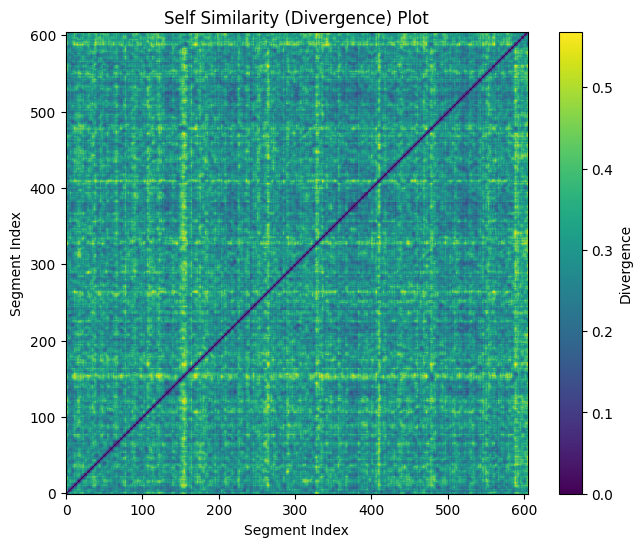

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pairwise_label_divergence(segments, metric='js', smoothing=1e-10):
    """
    Compute pairwise divergence between distributions of each segment of labels.

    Parameters:
        segments (np.ndarray): 2D array of shape (num_segments, window_size) containing labels.
        metric (str): Divergence metric to use: 'kl' for symmetric KL divergence,
                      'js' for Jensen-Shannon divergence.
        smoothing (float): Smoothing constant to add to counts for numerical stability.

    Returns:
        divergence_matrix (np.ndarray): Matrix of pairwise divergence values of shape (num_segments, num_segments).
    """
    # Determine the global unique categories across all segments
    global_categories = np.unique(segments)
    n_categories = len(global_categories)
    
    # Map each element in segments to its index in the global categories using np.searchsorted.
    # (global_categories is sorted by definition of np.unique)
    indices = np.searchsorted(global_categories, segments)
    
    # One-hot encode: result shape (num_segments, window_size, n_categories)
    one_hot = np.eye(n_categories)[indices]
    # Sum along window dimension to get counts per segment: shape (num_segments, n_categories)
    counts = one_hot.sum(axis=1)
    
    # Add smoothing and convert counts to probability distributions
    counts += smoothing
    distributions = counts / counts.sum(axis=1, keepdims=True)  # shape (N, n_categories)
    
    # Expand dims to compute pairwise divergences via broadcasting
    P = distributions  # shape: (N, n_categories)
    P_i = P[:, None, :]  # shape: (N, 1, n_categories)
    P_j = P[None, :, :]   # shape: (1, N, n_categories)
    
    if metric == 'js':
        # Compute the Jensen-Shannon divergence
        M = 0.5 * (P_i + P_j)
        kl1 = np.sum(P_i * np.log(P_i / M), axis=-1)
        kl2 = np.sum(P_j * np.log(P_j / M), axis=-1)
        divergence_matrix = 0.5 * (kl1 + kl2)
    elif metric == 'kl':
        # Compute symmetric KL divergence: 0.5*(KL(P||Q)+KL(Q||P))
        kl = np.sum(P_i * np.log(P_i / P_j), axis=-1)
        divergence_matrix = 0.5 * (kl + kl.T)
    else:
        raise ValueError("Unsupported metric. Choose 'kl' or 'js'.")
    
    return divergence_matrix

def plot_self_similarity(data, window_size=50, stride=10, threshold=None, cmap='viridis', metric='js'):
    """
    Generate and plot the self similarity (divergence) matrix for a 1D sequence of labels.
    
    Parameters:
        data (array-like): 1D array or list representing the time series of labels.
        window_size (int): The size of the sliding window used to create segments.
        stride (int): Step size for sliding window.
        threshold (float or None): If provided, the divergence matrix is thresholded to a binary matrix.
        cmap (str): Colormap used for the plot.
        metric (str): Divergence metric to use: 'kl' or 'js'.
    
    Returns:
        divergence_matrix (np.ndarray): The pairwise divergence matrix.
    """
    data = np.asarray(data)
    total_segments = len(data) - window_size + 1
    if total_segments < 1:
        raise ValueError("Data length must be at least equal to window_size")
    
    # Use numpy's sliding window view to create overlapping segments, then sub-sample with the given stride.
    segments = np.lib.stride_tricks.sliding_window_view(data, window_shape=window_size)[::stride]
    
    # Compute the divergence matrix in a vectorized fashion.
    divergence_matrix = compute_pairwise_label_divergence(segments, metric=metric)
    
    # Optionally threshold the divergence matrix to produce a binary plot.
    matrix_to_plot = (divergence_matrix >= threshold).astype(int) if threshold is not None else divergence_matrix

    plt.figure(figsize=(8, 6))
    plt.imshow(matrix_to_plot, origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(label='Divergence' if threshold is None else 'Binary Divergence')
    plt.title('Self Similarity (Divergence) Plot')
    plt.xlabel('Segment Index')
    plt.ylabel('Segment Index')
    plt.show()
    
    return divergence_matrix

# Example usage:
# For demonstration, generate synthetic label data.
# Here we generate 1000 labels chosen from 0 to 4.
data = df_annot["cluster"].values

# Plot the self similarity matrix with a window size of 50 and stride of 1 using Jensen-Shannon divergence.
divergence_matrix = plot_self_similarity(data, window_size=50, stride=10, metric='js')


In [105]:
divergence_matrix

array([[0.        , 0.10625229, 0.17994725, ..., 0.4973915 , 0.50671418,
        0.47726478],
       [0.10625229, 0.        , 0.09878314, ..., 0.45931164, 0.46087512,
        0.48307848],
       [0.17994725, 0.09878314, 0.        , ..., 0.39540845, 0.40996361,
        0.40444109],
       ...,
       [0.4973915 , 0.45931164, 0.39540845, ..., 0.        , 0.0767398 ,
        0.12893421],
       [0.50671418, 0.46087512, 0.40996361, ..., 0.0767398 , 0.        ,
        0.05369479],
       [0.47726478, 0.48307848, 0.40444109, ..., 0.12893421, 0.05369479,
        0.        ]])

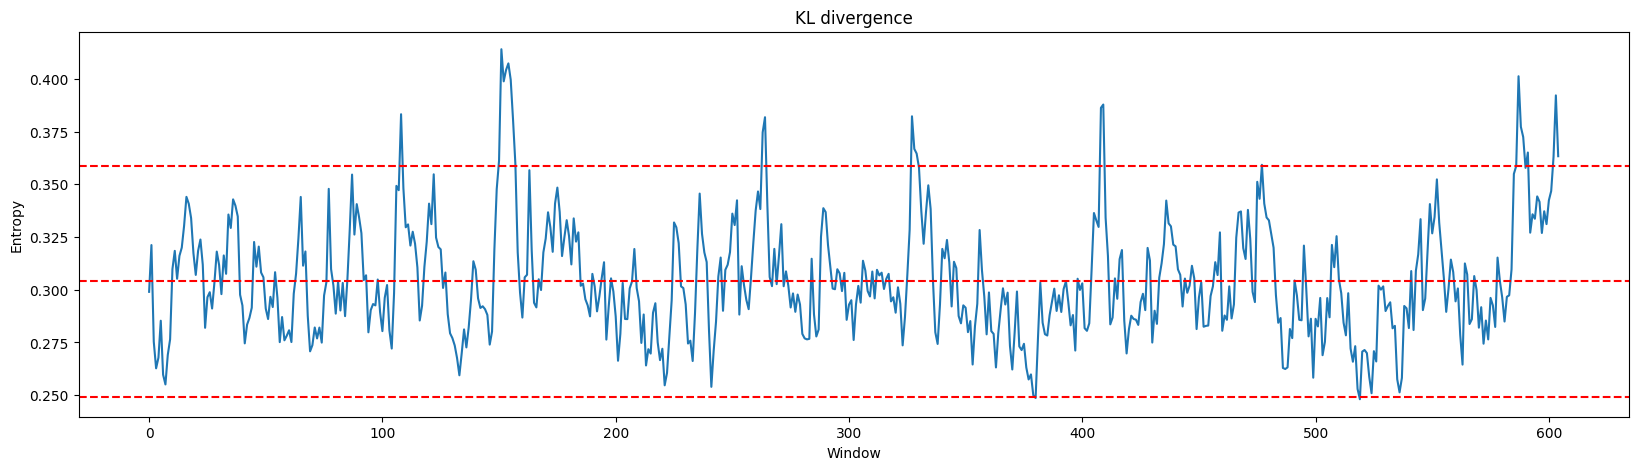

In [117]:
fig, ax = plt.subplots(figsize=(20, 5))  # Correct way to set figure size
ax.plot(divergence_matrix.mean(axis=0))
ax.set_xlabel("Window")
ax.set_ylabel("Entropy")
ax.set_title("KL divergence")
# add mean and std horizontal line
mean = divergence_matrix.mean(axis=0).mean()
std = divergence_matrix.mean(axis=0).std()
ax.axhline(mean, color='r', linestyle='--')
ax.axhline(mean + 2*std, color='r', linestyle='--')
ax.axhline(mean - 2*std, color='r', linestyle='--')
plt.show()




In [ ]:
embedding = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
coords_spectral = embedding.fit_transform(sim_matrix)

plt.figure(figsize=(6,5))
plt.scatter(coords_spectral[:,0], coords_spectral[:,1], c='red', edgecolor='k')
plt.title("Spectral Embedding Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
# calculate entropy on a rolling window of 50 rows of the dataframe
entropy = []
num_scan = 50
for i in range(0, len(df_annot) -num_scan, 1):
    print(i, i+num_scan)
    entropy.append(cal_entropy(df_annot["cluster"].iloc[i:i+num_scan].values))

In [ ]:
df_annot[df_annot["cluster"] == 37]["product"].value_counts()

In [ ]:
df_annot[df_annot["cluster"] == 29]["product"].value_counts()[:30]

In [223]:
df_annot[df_annot["product"].str.contains("XerC")]

,locus_tag,ftype,length_bp,gene,EC_number,COG,product,cluster
522,DFNOFNBE_00523,CDS,915,xerC_1,NaN,COG4973,Tyrosine recombinase XerC,37.0
3660,DFNOFNBE_03661,CDS,900,xerC_2,NaN,COG4973,Tyrosine recombinase XerC,37.0
4762,DFNOFNBE_04763,CDS,999,xerC_3,NaN,NaN,Tyrosine recombinase XerC,37.0
6044,DFNOFNBE_06045,CDS,1014,xerC_4,NaN,NaN,Tyrosine recombinase XerC,37.0


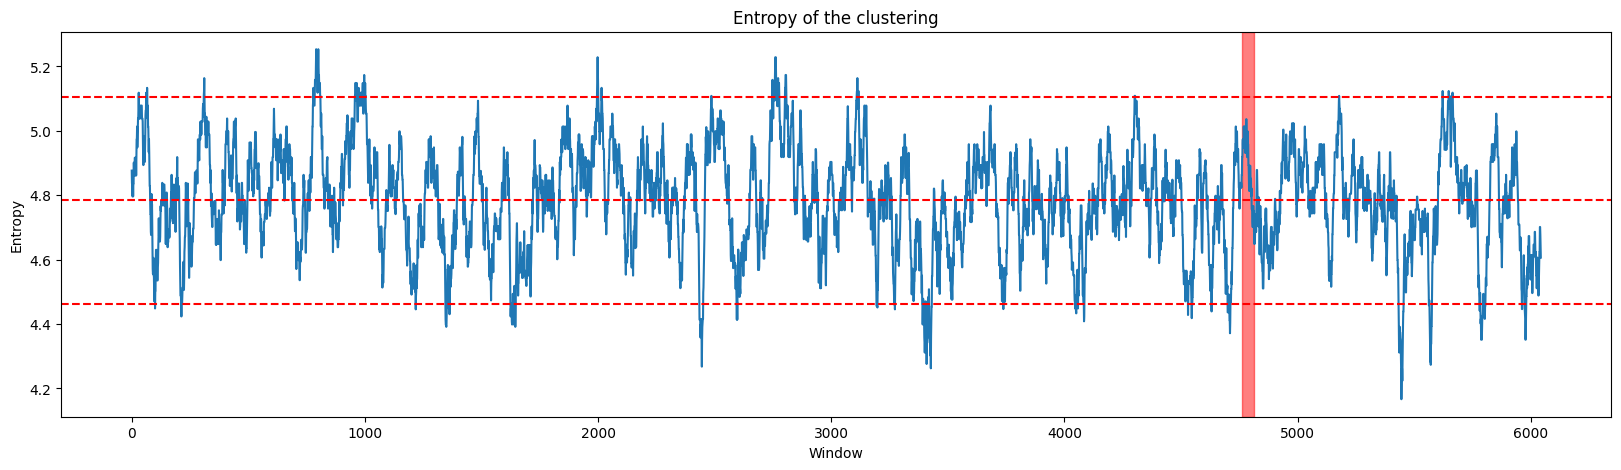

In [235]:

fig, ax = plt.subplots(figsize=(20, 5))  # Correct way to set figure size
ax.plot(entropy)  # Use ax to plot
ax.set_xlabel("Window")
ax.set_ylabel("Entropy")
ax.set_title("Entropy of the clustering")

# add hline for mean and mean +- 2sd
mean_entropy = np.mean(entropy)
std_entropy = np.std(entropy)
ax.axhline(mean_entropy, color='r', linestyle='--')
ax.axhline(mean_entropy + 2*std_entropy, color='r', linestyle='--')
ax.axhline(mean_entropy - 2*std_entropy, color='r', linestyle='--')

### add shade to region of interest from index 4763 to 4753+50
ax.axvspan(4763, 4763+50, color='red', alpha=0.5)
plt.show()  # Display the figure

Counter({21: 3,
         29: 3,
         30: 3,
         18: 5,
         7: 2,
         22: 7,
         15: 5,
         13: 2,
         24: 4,
         14: 6,
         26: 2,
         23: 1,
         6: 1,
         16: 1,
         5: 1,
         28: 3,
         27: 1})

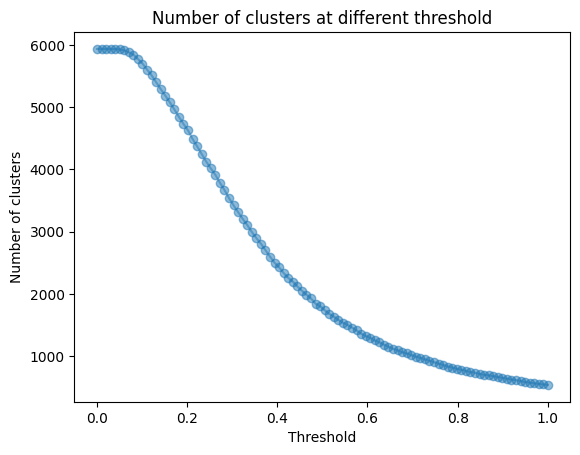

In [35]:
plt.plot(thresholds, n_cluster, marker = "o", alpha = 0.5)
plt.xlabel("Threshold")
plt.ylabel("Number of clusters")
plt.title("Number of clusters at different threshold")
plt.show()


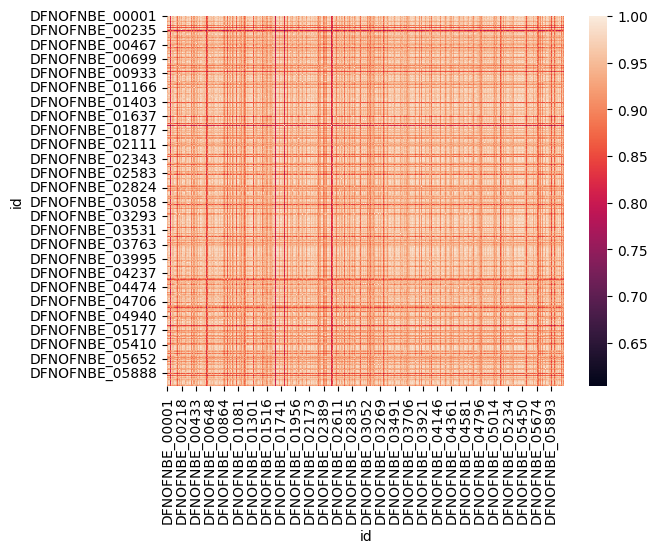

In [30]:
# visualize cosine similarity
sns.heatmap(cosine_sim)
plt.show()

In [65]:
# ### apply multiple kmeans clustering to find the best number of clusters
# inertia = []
# for i in range(1, 5):
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(df_pivot.iloc[:,1:])
#     inertia.append(kmeans.inertia_)
# plt.plot(range(1, 5), inertia)
# plt.show()

# kmeans = KMeans(n_clusters=5, random_state=0).fit(df_pivot.iloc[:,1:])
# clusters = kmeans.labels_

### apply multiple DBSCAN clustering to find the best number of clusters
# eps = np.linspace(0.1, 1, 10)
# min_samples = range(1, 5)

# for e in eps:
#     for m in min_samples:
#         dbscan = DBSCAN(eps=e, min_samples=m).fit(df_pivot.iloc[:,1:])
#         print(f"eps={e}, min_samples={m}, n_clusters={len(set(dbscan.labels_))}")

# dbscan = DBSCAN(eps=1., min_samples=5).fit(df_pivot.iloc[:,1:])
# clusters = dbscan.labels_

spectral = SpectralClustering(n_clusters=3, random_state=0).fit(df_pivot.iloc[:,1:])
clusters = spectral.labels_


Explained variation per principal component: [0.4810121  0.08254716 0.06698294]


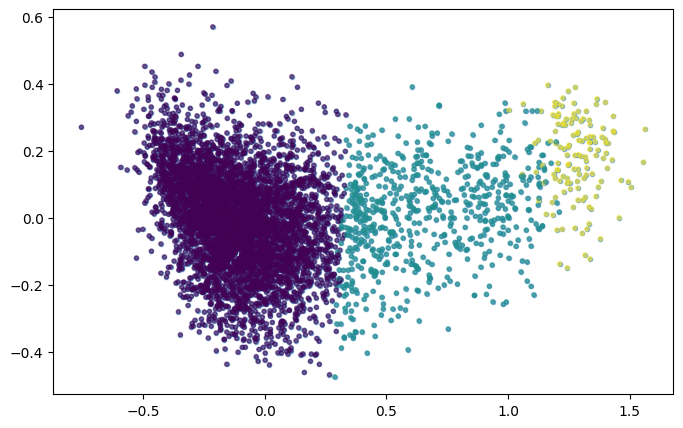

In [66]:
# apply PCA to embeddings
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_pivot.iloc[:,1:])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# plot PCA
plt.figure(figsize=(8,5))
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.5, marker=".")
# # plot color based on log of length
# plt.scatter(pca_result[:,0], pca_result[:,1], c=np.log(df_pivot["id"].apply(lambda x: id_length_dict[x])), alpha=0.5, marker=".")
# plt.colorbar()
# plot color based on kmeans clustering
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, alpha=0.5, marker=".")

plt.show()


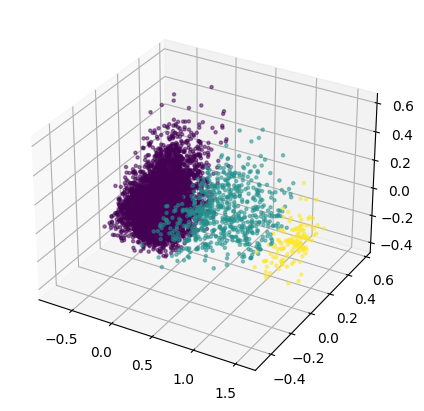

In [67]:
# plot 3D PCA
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], alpha=0.5, marker=".", c=clusters)
plt.show()


In [68]:
id_cluster_dict = dict(zip(df_pivot["id"], clusters))

In [69]:
df_annot["cluster"] = df_annot["locus_tag"].apply(lambda x: id_cluster_dict[x] if x in id_cluster_dict else -1)

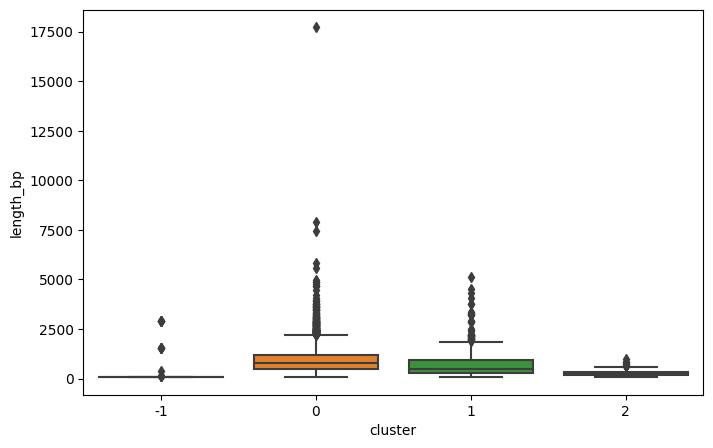

In [70]:
# plot boxplot of length
plt.figure(figsize=(8,5))
sns.boxplot(x="cluster", y="length_bp", data=df_annot)
plt.show()


In [48]:
df_annot

,locus_tag,ftype,length_bp,gene,EC_number,COG,product,cluster
0,DFNOFNBE_00001,CDS,186,NaN,NaN,NaN,hypothetical protein,1
1,DFNOFNBE_00002,CDS,930,NaN,NaN,NaN,hypothetical protein,2
2,DFNOFNBE_00003,CDS,1470,NaN,NaN,NaN,hypothetical protein,2
3,DFNOFNBE_00004,CDS,723,NaN,NaN,NaN,hypothetical protein,0
4,DFNOFNBE_00005,CDS,1821,acoR_1,NaN,COG3284,Acetoin catabolism regulatory protein,0
...,...,...,...,...,...,...,...,...
6089,DFNOFNBE_06090,CDS,303,NaN,NaN,NaN,hypothetical protein,2
6090,DFNOFNBE_06091,CDS,612,NaN,NaN,NaN,hypothetical protein,0
6091,DFNOFNBE_06092,CDS,858,rsrIM,2.1.1.72,NaN,Modification methylase RsrI,0
6092,DFNOFNBE_06093,CDS,411,NaN,NaN,NaN,hypothetical protein,0


In [77]:
df_annot[df_annot["cluster"]==2]["product"].value_counts()

hypothetical protein               128
Sulfurtransferase TusE               1
Ecotin                               1
Histidine ammonia-lyase              1
N-succinylarginine dihydrolase       1
IS4 family transposase ISPa1635      1
Name: product, dtype: int64

In [74]:
df_annot.groupby("cluster").agg({"length_bp":"mean", "product":"count", "product":list})

,length_bp,product
cluster,,
-1,329.091954,"[tRNA-Ser(tga), tRNA-Gly(gcc), tRNA-Gln(ctg), ..."
0,922.243693,"[Acetoin catabolism regulatory protein, sn-gly..."
1,725.453271,"[hypothetical protein, hypothetical protein, h..."
2,279.293233,"[hypothetical protein, Sulfurtransferase TusE,..."


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 6007 samples in 0.042s...
[t-SNE] Computed neighbors for 6007 samples in 1.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6007
[t-SNE] Computed conditional probabilities for sample 2000 / 6007
[t-SNE] Computed conditional probabilities for sample 3000 / 6007
[t-SNE] Computed conditional probabilities for sample 4000 / 6007
[t-SNE] Computed conditional probabilities for sample 5000 / 6007
[t-SNE] Computed conditional probabilities for sample 6000 / 6007
[t-SNE] Computed conditional probabilities for sample 6007 / 6007
[t-SNE] Mean sigma: 0.175630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.580742
[t-SNE] KL divergence after 300 iterations: 2.673199


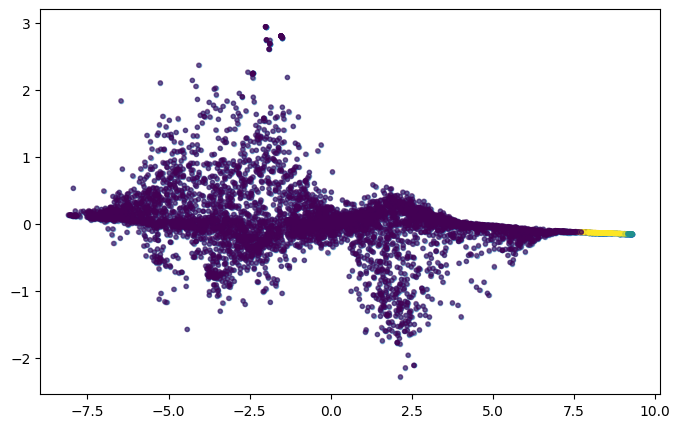

In [23]:
# apply tSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(df_pivot.iloc[:,1:])

# plot tSNE
plt.figure(figsize=(8,5))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5, marker=".")
# plot color based on cluster
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters, alpha=0.5, marker=".")

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


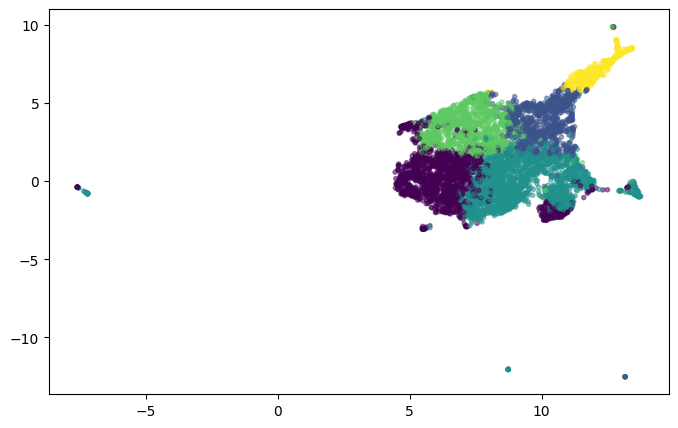

In [13]:
# Apply UMAP to embeddings
reducer = umap.UMAP()
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df_pivot.iloc[:,1:])
umap_result = reducer.fit_transform(pca_result)
# clustering on umap embeddings
clusters = KMeans(n_clusters=5, random_state=0).fit(df_pivot.iloc[:,1:]).labels_
# clusters = DBSCAN(eps=0.5, min_samples=5).fit(umap_result).labels_
plt.figure(figsize=(8,5))
plt.scatter(umap_result[:,0], umap_result[:,1], alpha=0.5, marker=".", c=clusters)
plt.show()
